In [109]:
##imports
import codecs  
import random  
import numpy as np
from sklearn.model_selection import train_test_split  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense  
from tensorflow.keras.models import Model  
import keras
from tensorflow.keras.utils import plot_model
import evaluation
import matplotlib.pyplot as plt
import pandas as pd
import preprocessing
import embedding_models
import create_model
from tensorflow.keras.callbacks import EarlyStopping


## Task 0: Read the file

In [2]:

# Load Portuguese sentences  
with codecs.open('data/europarl-v7.pt-en.pt', 'r', encoding='utf-8') as f:  
    portuguese_sentences = f.readlines()  

# Load English sentences  
with codecs.open('data/europarl-v7.pt-en.en', 'r', encoding='utf-8') as f:  
    english_sentences = f.readlines()  


## Task 1: Data exploration (10%) 
For this task you should extract some insights (i.e., some statistics and graphs) from the provided data. 
It could be the length differences between two languages and the number of sentences in the whole 
corpus. Don’t limit yourself into these examples and try to find more insights in the data. Please 
highlight some of the most important findings in your report.  
Moreover,  since  the  dataset  is too  large,  randomly select  10%  of  data (data sampling)  to  train your 
models on in the next steps. You can use a smaller sample in case 10% of the data is still too big to be 
trained in your local machine. 
Hint: if you faced codec errors in reading files, the “codecs” library could be used. 

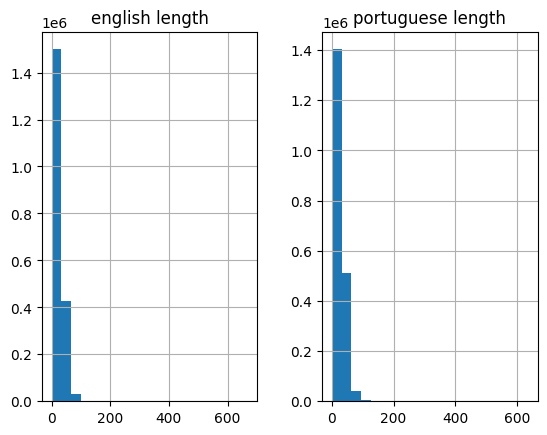

In [3]:
en_len = []
pt_len = []

# populate the lists with sentence lengths
for i in english_sentences:
      en_len.append(len(i.split()))  

for i in portuguese_sentences:
      pt_len.append(len(i.split()))

length_df = pd.DataFrame({'english length':en_len, 'portuguese length':pt_len})

length_df.hist(bins = 20)
plt.show()

## Task 2: Pre-processing (15%) 
In this task, first, apply all the necessary pre-processing steps that you think they would help to better 
prepare your data for the next steps.  You don’t have to apply all the pre-processing tasks which are 
covered in the course. Regarding the report, you should briefly mention it in your report that why you 
decided to apply the chosen pre-processing steps (and why not the others).  
Among all the pre-processing tasks, the following are recommended: 
● lowercase the text 
● strip empty lines and their correspondences 
● remove lines with XML-Tags (starting with "<") 


#### Select random 10% of the data

In [3]:
# random sampling of 10% of the data
sample_size = int(0.1 * len(portuguese_sentences))  
indices = random.sample(range(len(portuguese_sentences)), sample_size)  
sampled_portuguese_sentences = [portuguese_sentences[i] for i in indices]  
sampled_english_sentences = [english_sentences[i] for i in indices]  


#### Apply pre-processing steps

In [4]:
preprocessed_english, preprocessed_portuguese = preprocessing.apply_preprocessing_pipeline(sampled_english_sentences, sampled_portuguese_sentences)  


In [5]:

# Save the preprocessed data   
with codecs.open('data/preprocessed_english.en', 'w', encoding='utf-8') as f:  
    for sentence in preprocessed_english:  
        f.write(sentence + '\n')  
  
with codecs.open('data/preprocessed_portuguese.pt', 'w', encoding='utf-8') as f:  
    for sentence in preprocessed_portuguese:  
        f.write(sentence + '\n')  

## Task 3: Neural Machine Translation (45%) 
In  this  task  you  should  do  the  following  sub-tasks.  Choose  two  evaluation  metrics  and  report  your 
results using these two metrics. 
- Split data into train, validation and test sets. Use 20% of data as the test set. 
- Develop an RNN based  sequence to sequence model (encoder-decoder) to translate English 
input into Portuguese text. 
    - In your report describe your reasons for choosing the architecture that you are using 
for the task 
    - Track the impact of different embedding models (e.g., Glove, Word2Vec and ...) on 
the performance of your model. 
    - Interpret  the  results  of  your  model  in  the  report. Does the  length of  text  impact  on 
the  performance  of  the  model?  What  characteristic  of  sentences  led  to  better 
translation by the model? 
- Change your input and target languages (Translate from Portuguese to English) and train your 
mode again 
    - Compare the results in this step with the results from the previous step where English 
was the input language. 
- Develop a character-based model that train to translate characters into the target language. 
Compare  the  results  by  this  model  with  the  achieved  results  from  the  word-based  models 
before. 
Please report all the achieved results with either models in your report document. Moreover, describe 
the hyper-parameters of your neural network model in the report.



### Load preproccessed data from file

In [6]:
def load_data(english_file, portuguese_file, path = "data/"):  
    with codecs.open(path+english_file, 'r', encoding='utf-8') as f:  
        english_sentences = [line.strip() for line in f.readlines()] 
    with codecs.open(path+portuguese_file, 'r', encoding='utf-8') as f:  
        portuguese_sentences = [line.strip() for line in f.readlines()]
    return english_sentences, portuguese_sentences
  
english_sentences, portuguese_sentences = load_data('preprocessed_english.en', 'preprocessed_portuguese.pt')  

In [148]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('deu.txt', encoding="utf-8"):
    count += 1
    if count > 20000:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <end>'
    output_sentence_input = '<start> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


In [169]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('Hi.', 'Hallo! <end>', '<start> Hallo!')

In [150]:
train_decoder_inputs =output_sentences_inputs
train_decoder_targets =output_sentences

test_decoder_inputs =output_sentences_inputs
test_decoder_targets =output_sentences

val_decoder_inputs =output_sentences_inputs
val_decoder_targets =output_sentences

train_eng = input_sentences
test_eng = input_sentences
val_eng = input_sentences

### Split data into train, validation and test sets

In [112]:
train_eng, test_eng, train_pt, test_pt = train_test_split(english_sentences[:2000], portuguese_sentences[:2000], test_size=0.2, random_state=42)  # 20% of the data is used for testing
train_eng, val_eng, train_pt, val_pt = train_test_split(train_eng, train_pt, test_size=0.2, random_state=42) # 20% of the training data is used for validation  

In [170]:
train_eng[1], test_decoder_inputs[1], test_decoder_targets[1]

('Hi.', '<start> Hallo!', 'Hallo! <end>')

#### Prepare Decoder Input and Target Data

In [137]:
train_decoder_inputs = ['<start> ' + text for text in train_pt]
val_decoder_inputs = ['<start> ' + text for text in val_pt]
test_decoder_inputs = ['<start> ' + text for text in test_pt]

train_decoder_targets = [text + ' <end>' for text in train_pt]
val_decoder_targets = [text + ' <end>' for text in val_pt]
test_decoder_targets = [text + ' <end>' for text in test_pt]

### Tokenize and pad the data  

In [176]:
#train tokenizer on training data
train_eng_seq, eng_tokenizer = preprocessing.tokenize(train_eng)  
train_pt_seq_input, pt_tokenizer = preprocessing.tokenize(train_decoder_inputs, decode=True)  
train_pt_seq_target,_ = preprocessing.tokenize(train_decoder_targets, pt_tokenizer)

#apply the tokenizer to the test and validation data
test_eng_seq,_ = preprocessing.tokenize(test_eng,eng_tokenizer)
test_pt_seq_input,_  = preprocessing.tokenize(test_decoder_inputs, pt_tokenizer)
test_pt_seq_target,_  = preprocessing.tokenize(test_decoder_targets, pt_tokenizer)

val_eng_seq,_  = preprocessing.tokenize(val_eng,eng_tokenizer)
val_pt_seq_input,_  = preprocessing.tokenize(val_decoder_inputs, pt_tokenizer)
val_pt_seq_target,_  = preprocessing.tokenize(val_decoder_targets, pt_tokenizer)


#apply padding to the sequences
train_eng_seq, en_max_len = preprocessing.pad(train_eng_seq)
train_pt_seq_input,pt_max_len = preprocessing.pad(train_pt_seq_input)
train_pt_seq_target,_  = preprocessing.pad(train_pt_seq_target,pt_max_len)

test_eng_seq,_ = preprocessing.pad(test_eng_seq, en_max_len)
test_pt_seq_input,_ = preprocessing.pad(test_pt_seq_input, pt_max_len)
test_pt_seq_target,_  = preprocessing.pad(test_pt_seq_target, pt_max_len)

val_eng_seq,_ = preprocessing.pad(val_eng_seq, en_max_len)
val_pt_seq_input,_ = preprocessing.pad(val_pt_seq_input,pt_max_len)
val_pt_seq_target,_  = preprocessing.pad(val_pt_seq_target,pt_max_len)

#format (number of sentences, length of the longest sentence)
train_eng_seq.shape, train_pt_seq_input.shape, test_eng_seq.shape, test_pt_seq_input.shape, val_eng_seq.shape, val_pt_seq_input.shape 

((20000, 6), (20000, 11), (20000, 6), (20000, 11), (20000, 6), (20000, 11))

In [177]:
en_vocab_size = len(eng_tokenizer.word_index) # +1 for the PAD token which is assigned index 0
print('English Vocabulary Size: %d' % en_vocab_size)
print('English Max Length: %d' % (en_max_len))

pt_vocab_size = len(pt_tokenizer.word_index) 
print('Portuguese Vocabulary Size: %d' % pt_vocab_size)
print('Portuguese Max Length: %d' % (pt_max_len))


English Vocabulary Size: 3554
English Max Length: 6
Portuguese Vocabulary Size: 8121
Portuguese Max Length: 11


### Prepare the embedding matrix

In [180]:
importlib.reload(embedding_models)

<module 'embedding_models' from 'c:\\Users\\LUKE012\\Repository\\NLP_Project2_6_Marleen_Lukei\\embedding_models.py'>

In [181]:
# GloVe embeddings
glove_embeddings_index = embedding_models.load_glove_embeddings()
embedding_matrix_eng = embedding_models.apply_embedding_matrix(glove_embeddings_index, eng_tokenizer, embedding_dim=100)   #GloVe.6B.100d.txt has 100-dimensional embeddings 

embedding_matrix_eng.shape #(vocab in source, embedding dimension)

(3555, 100)

In [155]:
print(eng_tokenizer.word_index["join"])

462


In [156]:
glove_embeddings_index["join"]

array([-0.14029  ,  0.41191  , -0.26948  , -0.43433  ,  0.28881  ,
        0.19042  , -0.19125  ,  0.13532  , -0.21433  , -0.13725  ,
       -0.028824 , -0.42016  ,  0.14375  , -0.29691  , -0.46966  ,
       -0.73459  ,  0.61599  , -0.043419 , -0.61953  ,  0.0036096,
       -0.24429  , -0.22816  ,  0.07317  ,  0.040103 ,  0.08955  ,
       -0.15041  , -0.097695 , -0.56609  ,  1.5674   , -0.16712  ,
       -0.83527  ,  0.87894  ,  0.11907  , -0.53479  ,  0.5069   ,
        0.45844  ,  0.78871  , -0.31636  , -0.20366  , -0.1378   ,
       -0.97216  ,  0.077896 ,  0.39     , -0.25077  ,  0.1337   ,
        0.28206  , -0.20052  ,  0.39782  ,  0.096338 , -0.5235   ,
        0.03113  ,  0.16295  , -0.26507  ,  0.41499  , -0.018133 ,
       -2.1257   , -0.046183 , -0.71385  ,  1.2235   ,  0.74071  ,
       -0.095616 ,  0.30172  ,  0.065915 , -0.17511  ,  0.39778  ,
        0.41891  , -0.54643  ,  1.2686   , -0.091582 , -0.087319 ,
        0.31915  , -0.62008  , -1.1096   , -1.2698   , -0.3672

In [157]:
embedding_matrix_eng[462]

array([-0.14029001,  0.41191   , -0.26947999, -0.43432999,  0.28881001,
        0.19042   , -0.19125   ,  0.13531999, -0.21433   , -0.13725001,
       -0.028824  , -0.42016   ,  0.14375   , -0.29690999, -0.46966001,
       -0.73458999,  0.61598998, -0.043419  , -0.61953002,  0.0036096 ,
       -0.24428999, -0.22815999,  0.07317   ,  0.040103  ,  0.08955   ,
       -0.15041   , -0.097695  , -0.56608999,  1.56739998, -0.16711999,
       -0.83526999,  0.87893999,  0.11907   , -0.53478998,  0.50690001,
        0.45844001,  0.78871   , -0.31636   , -0.20366   , -0.13779999,
       -0.97215998,  0.077896  ,  0.38999999, -0.25077   ,  0.1337    ,
        0.28206   , -0.20051999,  0.39782   ,  0.096338  , -0.52350003,
        0.03113   ,  0.16294999, -0.26506999,  0.41499001, -0.018133  ,
       -2.1257    , -0.046183  , -0.71385002,  1.22350001,  0.74071002,
       -0.095616  ,  0.30171999,  0.065915  , -0.17511   ,  0.39778   ,
        0.41891   , -0.54642999,  1.26859999, -0.091582  , -0.08

### Create the model

In [187]:

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model = create_model.create_seq2seq_wordlevel_model(
                             name = "seq2seq_translation_model_en_to_pt",
                             embedding_matrix_encoder=embedding_matrix_eng,
                             source_vocab_size=en_vocab_size+1,
                             target_vocab_size=pt_vocab_size+1, 
                             max_len_encoder=en_max_len, 
                             max_len_decoder=pt_max_len, 
                             embedding_dim=100,
                             latent_dim=256)  
# Compile the model  
model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=['accuracy'])  
print(model.summary())


Model: "seq2seq_translation_model_en_to_pt"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 6, 100)    │    355,500 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 11, 256)   │  2,079,232 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    365,568 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 11, 256), │    525,312 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 11, 8122)  │  2,087,354 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,412,966 (20.65 MB)

 Trainable params: 5,412,966 (20.65 MB)

 Non-trainable params: 0 (0.00 B)

None


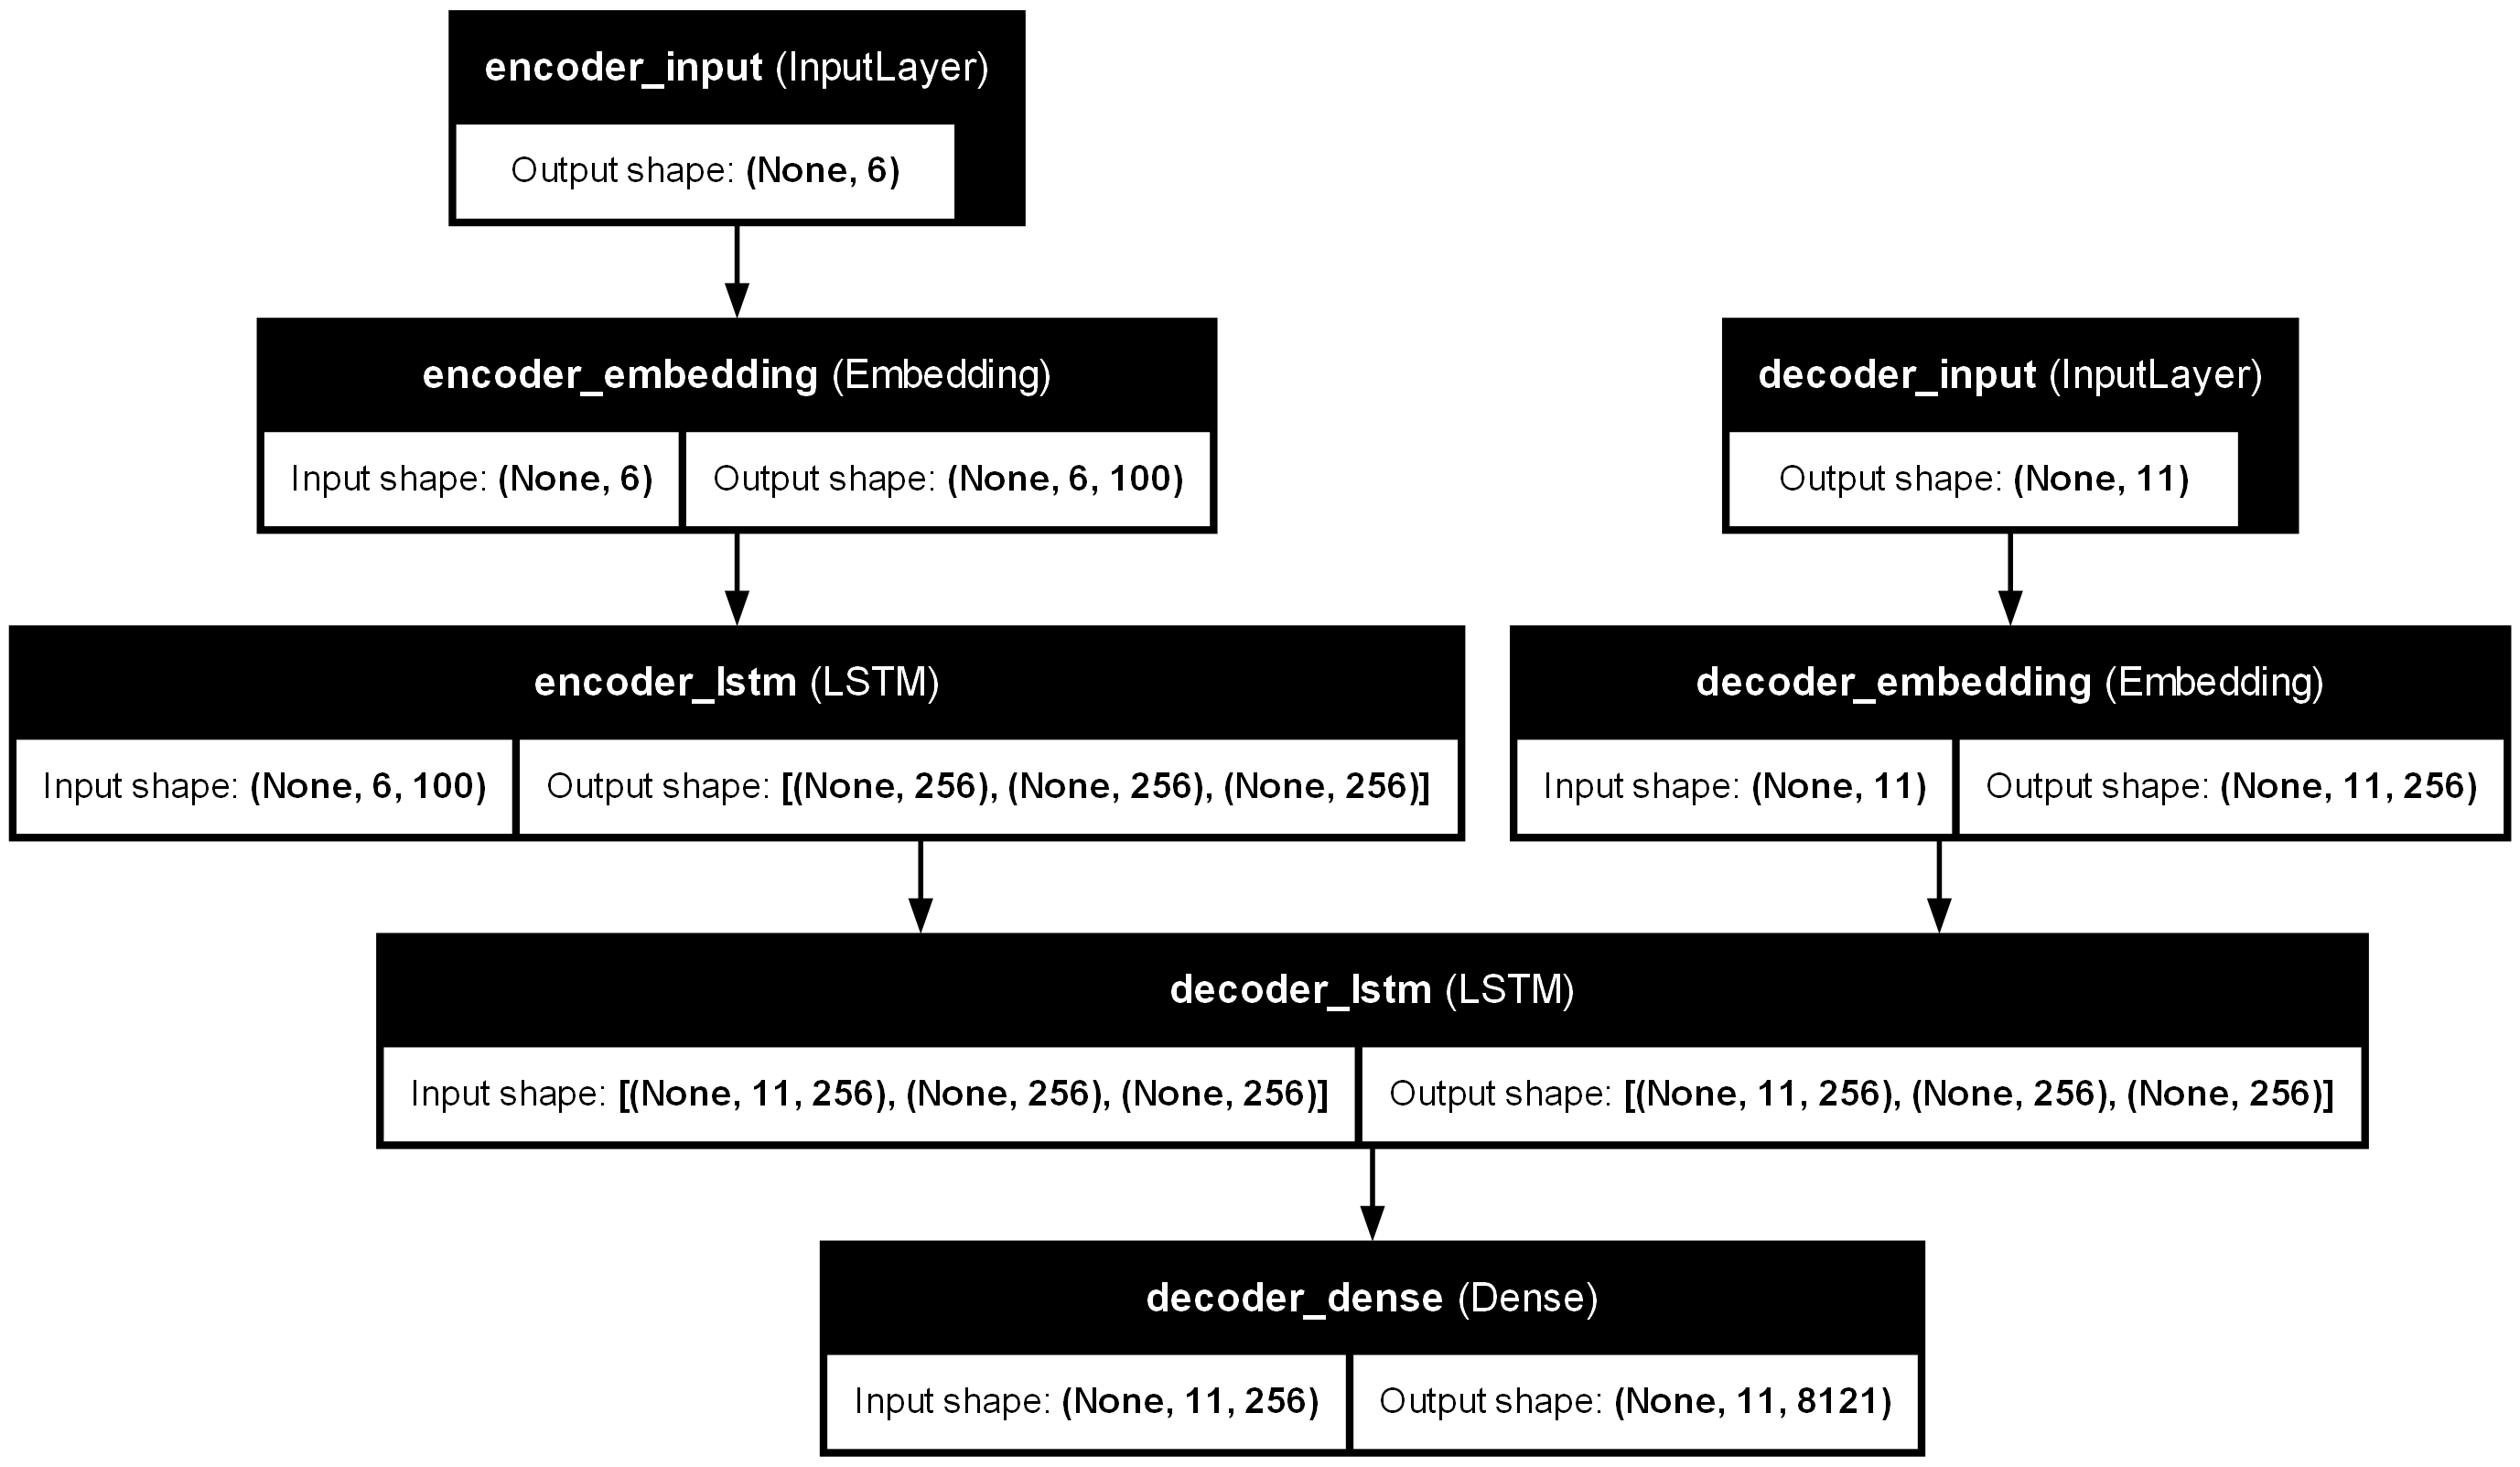

In [186]:
plot_model(model, to_file='plot/seq-to-seq-architecture-training.png', show_shapes=True, show_layer_names=True)

In [188]:
history = model.fit([train_eng_seq, train_pt_seq_input],  # Exclude <end> token from input
                    train_pt_seq_target,  # Target is shifted by one timestep
                    epochs=5,
                    batch_size=64,
                    #validation_data=([val_eng_seq, val_pt_seq_input], val_pt_seq_target),
                    validation_split=0.1,
                    callbacks=[callback])
model.save('models\seq2seq_translation_model_en_to_pt.h5')


Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 84s 281ms/step - accuracy: 0.6342 - loss: 3.2138 - val_accuracy: 0.6800 - val_loss: 2.4346
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 285ms/step - accuracy: 0.7206 - loss: 1.9920 - val_accuracy: 0.6953 - val_loss: 2.2548
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 85s 300ms/step - accuracy: 0.7403 - loss: 1.8404 - val_accuracy: 0.7130 - val_loss: 2.1135
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 111s 393ms/step - accuracy: 0.7574 - loss: 1.6880 - val_accuracy: 0.7255 - val_loss: 2.0164
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - accuracy: 0.7693 - loss: 1.5797 - val_accuracy: 0.7337 - val_loss: 1.9400


### Hyperparameter evaluation

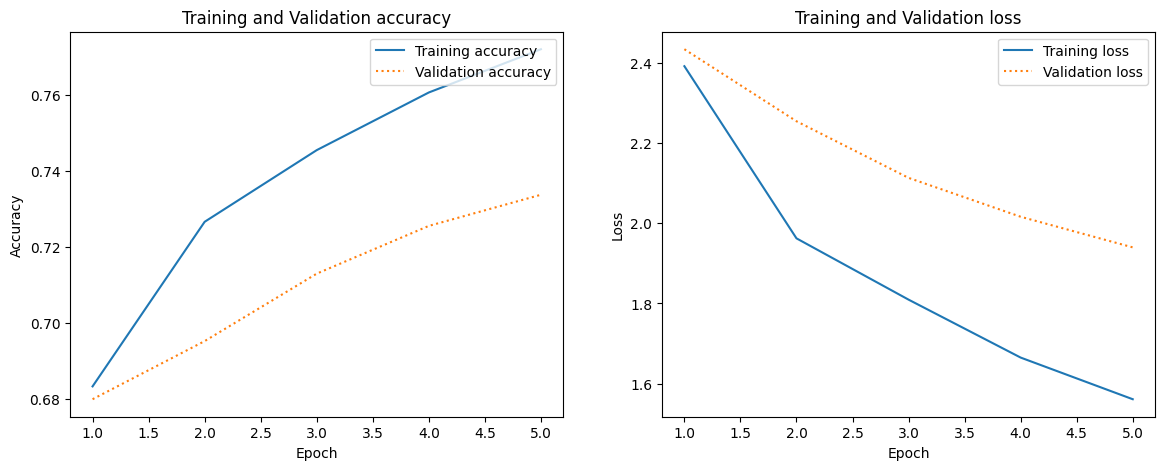

In [189]:
# accuracy and loss plots
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, accuracy, '-', label='Training accuracy')
ax1.plot(epochs, val_accuracy, ':', label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper right')

ax2.plot(epochs, loss, '-', label='Training loss')
ax2.plot(epochs, val_loss, ':', label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.show()

## Evaluate the model

In [96]:
model = keras.models.load_model('models\seq2seq_translation_model_en_to_pt.h5')

In [87]:
loss, accuracy = model.evaluate([test_eng_seq, test_pt_seq_input], test_pt_seq_target)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.7982 - loss: 1.4835
Test Loss: 1.4876928329467773
Test Accuracy: 0.7972047328948975


### Inference Setup

In [202]:
model.layers[5]

<LSTM name=decoder_lstm, built=True>

In [190]:
# Encoder model
encoder_inputs = model.input[0]
encoder_embedding = model.layers[2](encoder_inputs)
encoder_lstm = model.layers[4]
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Define encoder states
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.load_weights('models\seq2seq_translation_model_en_to_pt.h5')

In [193]:
encoder_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Embedding)   │ (None, 6, 100)         │       355,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, 256), (None,   │       365,568 │
│                                 │ 256), (None, 256)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,068 (2.75 MB)

 Trainable params: 721,068 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [204]:
# Decoder model

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = model.layers[3](decoder_inputs_single)  

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, h, c = model.layers[5](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = model.layers[6](decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


In [205]:
decoder_model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 1, 256)    │  2,079,232 │ input_layer_50[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_48      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_49      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 256),  │    525,312 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ input_layer_48[0… │
│                     │ (None, 256)]      │            │ input_layer_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 1, 8122)   │  2,087,354 │ decoder_lstm[1][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,691,898 (17.90 MB)

 Trainable params: 4,691,898 (17.90 MB)

 Non-trainable params: 0 (0.00 B)

In [206]:

def translate_sentence(input_seq, encoder_model, decoder_model, idx2word_target, pt_max_len,word2idx_outputs):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<start>']
    eos = word2idx_outputs['<end>']
    output_sentence = []

    for _ in range(pt_max_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [210]:
idx2word_target = {v:k for k, v in pt_tokenizer.word_index.items()} # index to word mapping for target language
word2idx_outputs = pt_tokenizer.word_index

i = np.random.choice(len(train_eng))
input_seq = train_eng_seq[i:i+1]
translation = translate_sentence(input_seq, encoder_model, decoder_model, idx2word_target, pt_max_len, word2idx_outputs)
print('Input Language : ', train_eng[i])
print('Actual translation : ', train_decoder_targets[i])
print('Portugese translation : ', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Input Language :  Tom got busted.
Actual translation :  Tom wurde geschnappt. <end>
Portugese translation :  tom hat tom nicht sein.


#### Bleu Score

In [211]:
# Evaluate the model  
bleu_score = evaluation.calculate_bleu(model, test_eng_seq, test_pt_seq_input)  
print(f'BLEU Score: {bleu_score}')  


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step


: 

#### METEOR Score

In [22]:
# Evaluate using METEOR
meteor_score = evaluation.calculate_meteor(model, test_eng_seq, test_pt_seq_input, pt_tokenizer)
print(f'METEOR Score: {meteor_score}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
METEOR Score: 0.0491141762429618
